In [1]:
from __future__ import division
from scipy.integrate import odeint,ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace,cos,pi,hstack
from numpy.random import uniform,normal,choice
import pylab as plt
import numpy as np
%matplotlib inline

In [2]:
def MSE(A,B):
    return np.square(np.subtract(A,B)).mean()

## Define our RLSQ solution for the sine-wave task

In [3]:
def rslq_ours(nneur):
    '''
    RLSQ implementation for learning low-rank RNN
    '''
    
    mse_all=[]
    trace_all=[]
    
    ## Average results over 5 seeds
    for k in range(5):
        dt      = 1.0
        T       = 800
        tgrid   = np.arange(T) * dt
        target  = lambda t: np.cos(2 * np.pi * t / 50)
        z_traj  = target(tgrid)                # shape (T,)

        # Compute running integral Zint[i]
        Zint = np.zeros(T)
        for i in range(1, T):
            Zint[i] = Zint[i-1] + dt * z_traj[i-1]


        # Design matrix Xd: T x nneur: need atleast 2 dimensions to obtain periodic signal
        nd       = 2

        # Set m matrix and bias b
        mmat = np.random.randn(nneur, nd)   
        b    = np.random.randn(nneur, 1)    

        def g(x):
            return np.tanh(x)

        # rename for consistency
        xgridvec = z_traj     # (T,)
        ygridvec = Zint       # (T,)

        # Create design matrix Xd (T × nneur)
        Xd = (g(mmat[:, 0].reshape(-1, 1) @ xgridvec.reshape(1, -1)
                + mmat[:, 1].reshape(-1, 1) @ ygridvec.reshape(1, -1)
                + b).T)

        # Define Target Y [ dz dzInt]
        dz    = np.diff(z_traj, prepend=z_traj[0]) / dt  # (T,)
        dZint = z_traj                                  # (T,) since integral of dz = z

        Y = np.vstack((dz+z_traj, dZint)).T            # shape (T,2)

        
        # OUR RLS SOLUTION nmat (nneur×2)
        
        P     = np.eye(nneur)   # ridge regression prior
        nmat  = np.zeros((nneur, 2))   # weight matrix mapping features to 2 outputs
        err_trace = []

        for i in range(T):
            phi_i = Xd[i][:, None]                    # (nneur,1)
            Pphi  = P @ phi_i                         # (nneur,1)
            gain  = (Pphi / (1.0 + float(phi_i.T @ Pphi))).flatten()  # (nneur,) 
            err   = Y[i] - (Xd[i] @ nmat)             # (2,)
            err_trace.append(np.linalg.norm(err))
            nmat += gain[:, None] * err[None, :]      # update each column
            P    -= np.outer(gain, Pphi.flatten())    # update covariance
        trace_all.append(err_trace)
        
        
        # Predict and compute the error 
        
        Y_hat = Xd @ nmat  # (T,2)
        mse_cur = MSE(Y[:,0],Y_hat[:,0])
        mse_all.append(mse_cur)
    trace_all = np.array(trace_all)
    mean_trace = trace_all.mean(axis=0)
    return np.sum(mse_all)/len(mse_all),Y_hat[:,0] ,mean_trace

## FORCE implementation on the same task

In [4]:
def force_method(n_cur):
    mse_avg=[]
    error_all=[]
    
    for k in range(5):
        ## run for 5 seeds, just like ours
        g = 1.5
        N = n_cur
        x0 = uniform(-0.5,0.5,N)
        t = linspace(0,50,500)
        u = uniform(-1,1,N)

        def f3(t0,x):
            return -x + g*dot(J,tanh_x) + dot(w,tanh_x)*u

        target = lambda t0: cos(2*pi*t0/50) # target pattern

        J = normal(0,sqrt(1/N),(N,N))
        dt = 1       # time step
        tmax = 800   # simulation length
        w = uniform(-1/sqrt(N),1/sqrt(N),N) # initial weights
        P = eye(N) # Running estimate of the inverse correlation matrix
        lr = 1.0 # learning rate

        # simulation data: state, output, time, weight updates
        x,z,t,wu = [x0],[],[0],[0]

        # Set up ode solver
        solver = ode(f3)
        solver.set_initial_value(x0)

        # Integrate ode, update weights, repeat
        error_cur=[]
        while t[-1] < tmax:
            tanh_x = tanh(x[-1]) # cache 
            z.append(dot(w,tanh_x))
            error = target(t[-1]) - z[-1]
            q = dot(P,tanh_x)
            c = lr / (1 + dot(q,tanh_x))
            P = P - c*outer(q,q)
            w = w + c*error*q

            if t[-1]>300: lr = 0

            wu.append(np.sum(np.abs(c*error*q)))

            solver.integrate(solver.t+dt)
            x.append(solver.y)
            t.append(solver.t)
            error_cur.append(np.linalg.norm(error))
        error_all.append(error_cur)
        # last update for readout neuron
        z.append(dot(w,tanh_x))
        t = np.array(t)
        mse_cur = MSE(target(t),z)
        mse_avg.append(mse_cur)
    error_all = np.array(error_all)
    error_all = error_all.mean(axis=0)
    return np.sum(mse_avg)/len(mse_avg), z, error_all

## Run FORCE and Our method on different network sizes to compare results

In [5]:
N_list = [2,4, 8, 16, 32, 64, 128, 256, 512, 1024]
mse_all_force=[]
mse_all_ours=[]
mean_error_ours=[]
mean_error_force=[]
z_all_ours=[]
z_all_force=[]
for i,n_cur in enumerate(N_list):
    print("in n_cur:", n_cur)
    # if i==len(N_list)-1:
    mse_cur, z_final,mean_error_force_cur = force_method(n_cur)
    mse_cur_ours,z_final_ours,mean_error_ours_cur = rslq_ours(n_cur)
    # else:
    #     mse_cur, _ = force_method(n_cur)
    #     mse_cur_ours,_ = rslq_ours(n_cur)
    mse_all_force.append(mse_cur)
    mse_all_ours.append(mse_cur_ours)
    z_all_ours.append(z_final_ours)
    z_all_force.append(z_final)
    mean_error_ours.append(mean_error_ours_cur)
    mean_error_force.append(mean_error_force_cur)

in n_cur: 2
in n_cur: 4
in n_cur: 8
in n_cur: 16
in n_cur: 32
in n_cur: 64
in n_cur: 128
in n_cur: 256
in n_cur: 512
in n_cur: 1024


## Plot Results

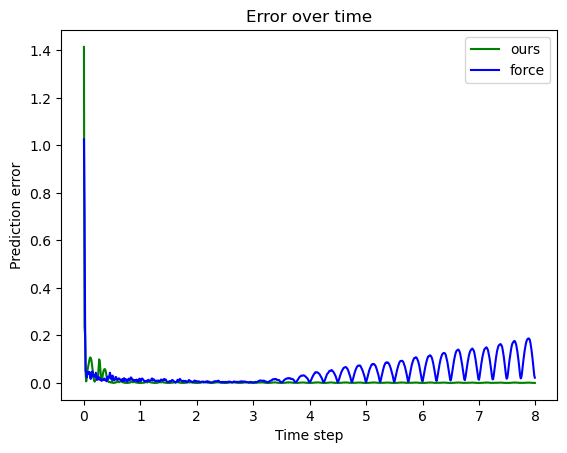

In [22]:
# Plot error reduction over time
# plt.figure()

fig, ax = plt.subplots()
ax.plot(mean_error_ours[-1],color='g', label='ours')                    # same call as before
ax.plot(mean_error_force[-1],color='b', label = 'force') 
ax.set_xlabel("Time")
ax.set_ylabel("Prediction error (L2 norm)")
ax.set_title("Error over time")
# put ticks every 100 steps and label them 0–8
ticks   = np.arange(0, 801, 100)      # 0, 100, 200, …, 800
labels  = np.arange(0, 9)             # 0, 1, 2, …, 8
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

plt.xlabel("Time step")
plt.ylabel("Prediction error")
plt.title("Error over time")
plt.legend()
plt.show()

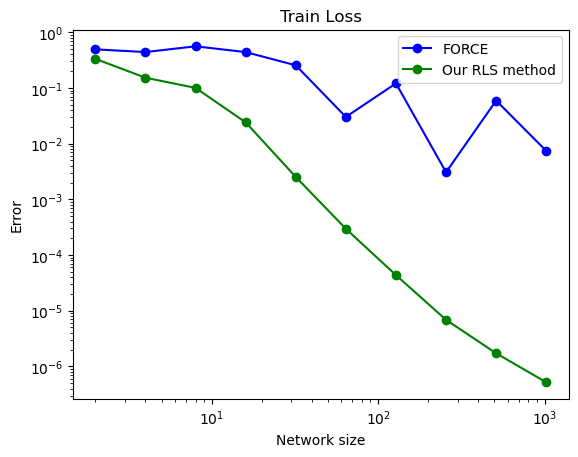

In [23]:
plt.plot(N_list, mse_all_force,'bo-',label='FORCE')
plt.plot(N_list, mse_all_ours,'go-',label='Our RLS method')
plt.title('Train Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Network size')
plt.ylabel('Error')
plt.legend()
plt.show()

## Also plot an example of the trajectory from n/ws trained via our method vs FORCE

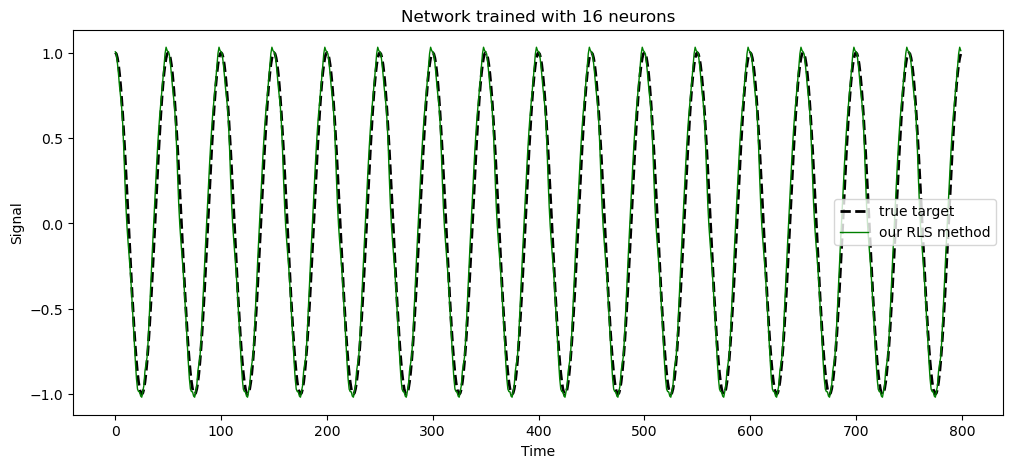

In [24]:
target = lambda t0: cos(2*pi*t0/50) # target pattern
dt      = 1.0
T       = 800
tgrid   = np.arange(T) * dt
t = np.array(tgrid)
plt.figure(figsize=(12, 5))
plt.plot(t,target(t),'k--',lw=2, label='true target')
plt.plot(t,z_all_ours[4],'g',lw=1, label= 'our RLS method')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Network trained with 16 neurons')
plt.legend()
plt.show()

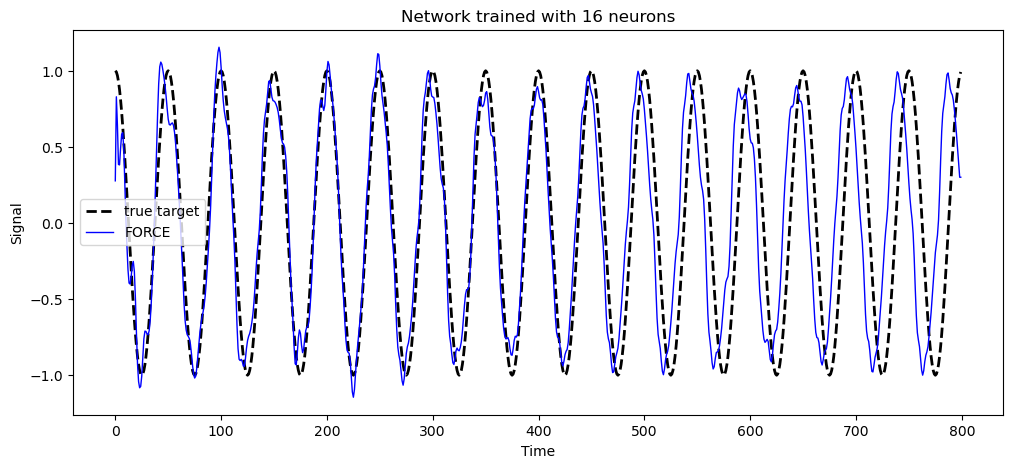

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(t,target(t),'k--',lw=2,label='true target')
plt.plot(t,z_all_force[4][1:],'b',lw=1,label='FORCE')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Network trained with 16 neurons')
plt.legend()
plt.show()